# Model Fit in Linear Regression - Lab

## Introduction
In this lab, you'll learn how to evaluate your model results, and you'll learn methods to select the appropriate features using stepwise selection.

## Objectives
You will be able to:
* Analyze the results of regression and R-squared and adjusted-R-squared 
* Understand and apply forward and backward predictor selection

## The Boston Housing Data once more

We pre-processed the Boston Housing Data the same way we did before:

- We dropped "ZN" and "NOX" completely
- We categorized "RAD" in 3 bins and "TAX" in 4 bins
- We used min-max-scaling on "B", "CRIM" and "DIS" (and logtransformed all of them first, except "B")
- We used standardization on "AGE", "INDUS", "LSTAT" and "PTRATIO" (and logtransformed all of them first, except for "AGE") 

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()

boston_features = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_features = boston_features.drop(["NOX","ZN"],axis=1)

# first, create bins for based on the values observed. 3 values will result in 2 bins
bins = [0,6,  24]
bins_rad = pd.cut(boston_features['RAD'], bins)
bins_rad = bins_rad.cat.as_unordered()

# first, create bins for based on the values observed. 4 values will result in 3 bins
bins = [0, 270, 360, 712]
bins_tax = pd.cut(boston_features['TAX'], bins)
bins_tax = bins_tax.cat.as_unordered()

tax_dummy = pd.get_dummies(bins_tax, prefix="TAX")
rad_dummy = pd.get_dummies(bins_rad, prefix="RAD")
boston_features = boston_features.drop(["RAD","TAX"], axis=1)
boston_features = pd.concat([boston_features, rad_dummy, tax_dummy], axis=1)

age = boston_features["AGE"]
b = boston_features["B"]
logcrim = np.log(boston_features["CRIM"])
logdis = np.log(boston_features["DIS"])
logindus = np.log(boston_features["INDUS"])
loglstat = np.log(boston_features["LSTAT"])
logptratio = np.log(boston_features["PTRATIO"])

# minmax scaling
boston_features["B"] = (b-min(b))/(max(b)-min(b))
boston_features["CRIM"] = (logcrim-min(logcrim))/(max(logcrim)-min(logcrim))
boston_features["DIS"] = (logdis-min(logdis))/(max(logdis)-min(logdis))

#standardization
boston_features["AGE"] = (age-np.mean(age))/np.sqrt(np.var(age))
boston_features["INDUS"] = (logindus-np.mean(logindus))/np.sqrt(np.var(logindus))
boston_features["LSTAT"] = (loglstat-np.mean(loglstat))/np.sqrt(np.var(loglstat))
boston_features["PTRATIO"] = (logptratio-np.mean(logptratio))/(np.sqrt(np.var(logptratio)))

In [17]:
predictors_int = sm.add_constant(boston_features)
model = sm.OLS(boston.target, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     144.9
Date:                Tue, 02 Jul 2019   Prob (F-statistic):          5.08e-153
Time:                        13:53:09   Log-Likelihood:                -1458.2
No. Observations:                 506   AIC:                             2942.
Df Residuals:                     493   BIC:                             2997.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.4607      1.789      2.493      0.013       0.946       7.976
CRIM              -1.9538      2.115     -0.924      0.356      -6.110       2.202
INDUS             -0.8046      0.362     -2.220      0.027      -1.517      -0.093
CHAS               2.5959      0.796      3.260      0.001       1.032       4.160
RM                 2.6466      0.408      6.488      0.000       1.845       3.448
AGE                0.0794      0.352      0.226      0.821      -0.612       0.770
DIS              -10.0962      1.856     -5.439      0.000     -13.743      -6.449
PTRATIO           -1.4867      0.241     -6.160      0.000      -1.961      -1.013
B                  3.8412      0.986      3.897      0.000       1.905       5.778
LSTAT             -5.6288      0.354    -15.912      0.000      -6.324      -4.934
RAD_(0, 6]         1.5613      0.821      1.901      0.058      -0.052       3.175
RAD_(6, 24]        2.8993      1.073      2.701      0.007       0.791       5.008
TAX_(0, 270]       2.6222      0.716      3.665      0.000       1.216       4.028
TAX_(270, 360]     1.3624      0.704      1.936      0.053      -0.020       2.745
TAX_(360, 712]     0.4761      0.684      0.696      0.487      -0.868       1.820
==============================================================================
Omnibus:                      106.730   Durbin-Watson:                   1.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              432.101
Skew:                           0.891   Prob(JB):                     1.48e-94
Kurtosis:                       7.162   Cond. No.                     5.67e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.79e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Perform stepwise selection

The code for stepwise selection is copied below.

In [3]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [5]:
y=boston.target
X= boston_features

In [7]:
result = stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True)

Add  LSTAT                          with p-value 9.27989e-122
Add  RM                             with p-value 1.98621e-16
Add  PTRATIO                        with p-value 2.5977e-12
Add  DIS                            with p-value 2.85496e-09
Add  B                              with p-value 2.77572e-06
Add  TAX_(0, 270]                   with p-value 0.000855799
Add  CHAS                           with p-value 0.00151282
Add  INDUS                          with p-value 0.00588575


In [10]:
X_new= X[result]
X_new.head()

,LSTAT,RM,PTRATIO,DIS,B,"TAX_(0, 270]",CHAS,INDUS
0,-1.275260,6.575,-1.443977,0.542096,1.000000,0,0.0,-1.704344
1,-0.263711,6.421,-0.230278,0.623954,1.000000,1,0.0,-0.263239
2,-1.627858,7.185,-0.230278,0.623954,0.989737,1,0.0,-0.263239
3,-2.153192,6.998,0.165279,0.707895,0.994276,1,0.0,-1.778965
4,-1.162114,7.147,0.165279,0.707895,1.000000,1,0.0,-1.778965


### Build the final model again in Statsmodels

In [18]:
X_new = sm.add_constant(X_new)
model = sm.OLS(y, X_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     215.7
Date:                Tue, 02 Jul 2019   Prob (F-statistic):          2.69e-156
Time:                        13:53:54   Log-Likelihood:                -1461.3
No. Observations:                 506   AIC:                             2941.
Df Residuals:                     497   BIC:                             2979.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.8980      2.813      1.742      0.082      -0.628      10.424
LSTAT           -5.5932      0.319    -17.538      0.000      -6.220      -4.967
RM               2.8294      0.386      7.333      0.000       2.071       3.587
PTRATIO         -1.3265      0.226     -5.878      0.000      -1.770      -0.883
DIS             -9.1984      1.333     -6.898      0.000     -11.818      -6.579
B                3.9052      0.931      4.195      0.000       2.076       5.734
TAX_(0, 270]     1.4418      0.552      2.614      0.009       0.358       2.526
CHAS             2.7988      0.791      3.539      0.000       1.245       4.353
INDUS           -0.9574      0.346     -2.766      0.006      -1.637      -0.277
==============================================================================
Omnibus:                      114.307   Durbin-Watson:                   1.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.579
Skew:                           0.945   Prob(JB):                    1.62e-105
Kurtosis:                       7.395   Cond. No.                         96.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Where our stepwise procedure mentions that "CHAS" was added with a p-value of 0.00151282, but our statsmodels output returns a p-value of 0.000. What is the intuition behind this?

## Use Feature ranking with recursive feature elimination

Use feature ranking to select the 5 most important features

## Make sure the variables are normalized so that their scales are smilar. 

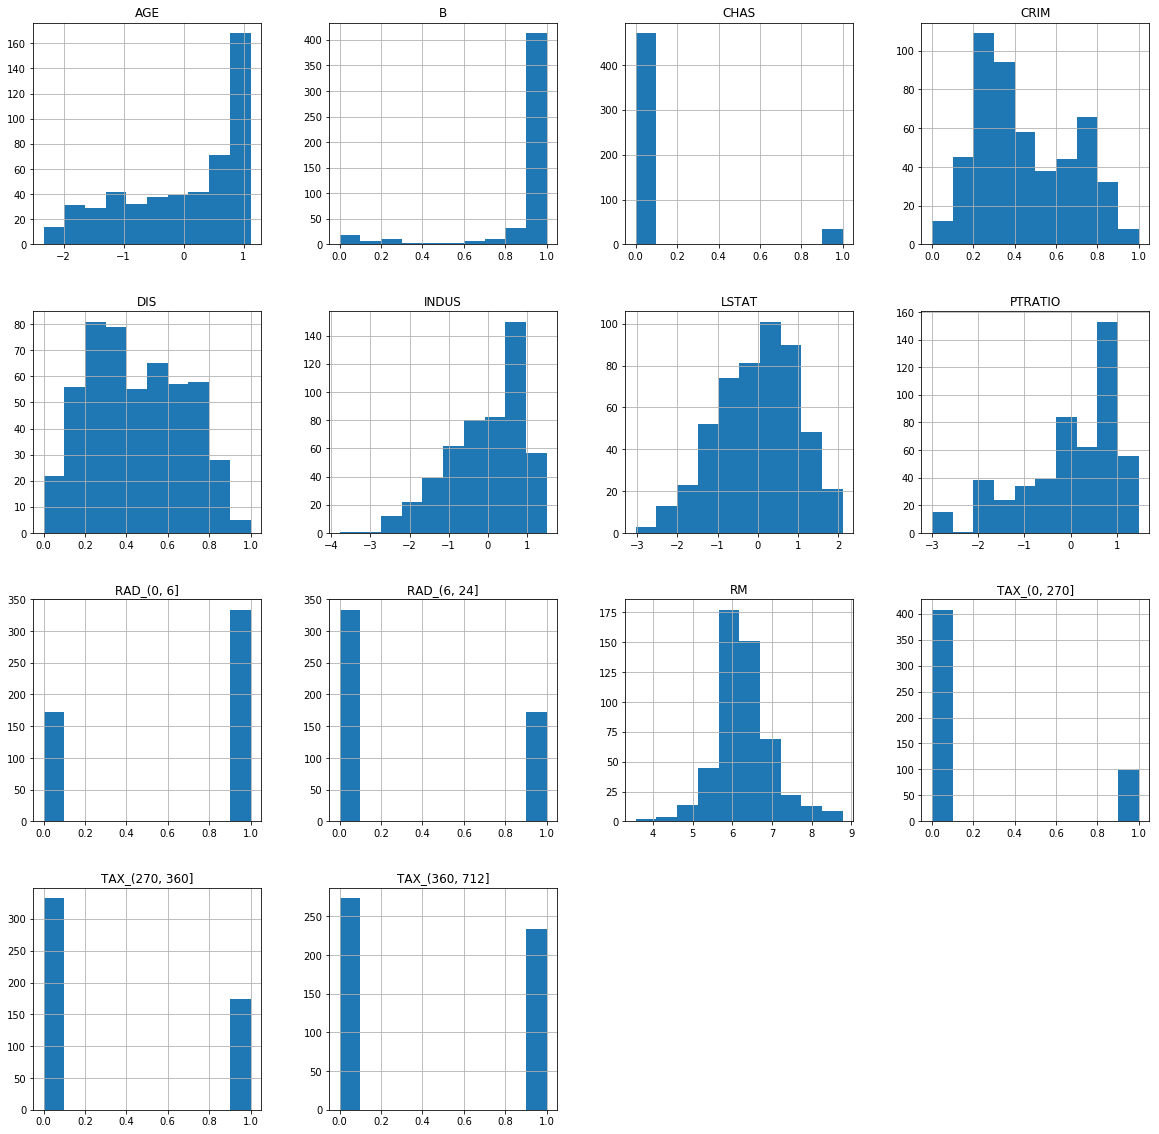

In [21]:
boston_features.hist(figsize=(20,20));

In [22]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [23]:
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 2)
selector =selector.fit(boston_features, boston.target)

In [24]:
selector.support_

array([False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False])

Fit the linear regression model again using the 5 columns selected

In [39]:
selected = boston_features.columns[selector.support_]
X = boston_features[selected]

In [41]:
y= pd.DataFrame(boston.target, columns =['price'])
linreg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Now, predict $\hat y$ using your model. you can use `.predict()` in scikit-learn

In [49]:
y_hat = linreg.predict(X)

In [47]:
X_int = sm.add_constant(X)
modelREF= sm.OLS(y,X_int).fit()
modelREF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     560.3
Date:                Tue, 02 Jul 2019   Prob (F-statistic):          1.04e-128
Time:                        14:21:23   Log-Likelihood:                -1543.8
No. Observations:                 506   AIC:                             3094.
Df Residuals:                     503   BIC:                             3106.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9230      0.577     44.951      0.000      24.790      27.056
DIS           -7.5474      1.179     -6.400      0.000      -9.864      -5.231
LSTAT         -8.3910      0.268    -31.333      0.000      -8.917      -7.865
==============================================================================
Omnibus:                       81.880   Durbin-Watson:                   1.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.469
Skew:                           0.913   Prob(JB):                     2.35e-35
Kurtosis:                       5.056   Cond. No.                         6.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, using the formulas of R-squared and adjusted-R-squared below, and your Python/numpy knowledge, compute them and contrast them with the R-squared and adjusted-R-squared in your statsmodels output using stepwise selection. Which of the two models would you prefer?

$SS_{residual} = \sum (y - \hat{y})^2 $

$SS_{total} = \sum (y - \bar{y})^2 $

$R^2 = 1- \dfrac{SS_{residual}}{SS_{total}}$

$R^2_{adj}= 1-(1-R^2)\dfrac{n-1}{n-p-1}$

In [51]:
SS_Residual = np.sum((y-y_hat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)

In [54]:
print('SSR = ', SS_Residual,'\n', 'SST = ', SS_Total, '\n',
      'R^2 = ', r_squared, '\n', 'adjR^2 = ', adjusted_r_squared)

SSR =  price    13234.482394
dtype: float64 
 SST =  price    42716.295415
dtype: float64 
 R^2 =  price    0.690177
dtype: float64 
 adjR^2 =  price    0.688945
dtype: float64


## Level up - Optional

- Perform variable selection using forward selection, using this resource: https://planspace.org/20150423-forward_selection_with_statsmodels/. Note that this time features are added based on the adjusted-R-squared!
- Tweak the code in the `stepwise_selection()`-function written above to just perform forward selection based on the p-value.

## Summary
Great! You now performed your own feature selection methods!